In [8]:
# Load packages
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import FancyArrow
from matplotlib.patches import FancyArrowPatch
import xlrd
import folium
from folium.plugins import FloatImage
from branca.colormap import LinearColormap
from shapely.ops import unary_union
from shapely.validation import make_valid
import os
import math
from math import atan2, degrees
from folium import IFrame
import base64
import requests
from folium import Map, Element

In [3]:
# Set the base directory to the repository root
base_dir = Path().resolve().parent
print(base_dir)

/Users/sunny/Documents/GitHub/india-election


**NDA 2024 vs 2019**

In [6]:
geo_nda_compare = gpd.read_file(base_dir / "geo-datasets/geo_nda_compare.geojson")
geo_nda_compare_nomiss = gpd.read_file(base_dir / "geo-datasets/geo_nda_compare_nomiss.geojson")

In [ ]:
# Load geodatasets
geo_nda_2024 = gpd.read_file(base_dir / "geo-datasets/geo_nda_2024.geojson")

In [ ]:
geo_nda_2019 = gpd.read_file(base_dir / "geo-datasets/geo_nda_2019.geojson")

In [ ]:
# label cols as 2019 and 2024
geo_nda_2019.columns
cols_to_tag = ['Candidate', 'Party', 'Total Votes', 'Total Votes Cast', 'Vote Share (%)']

# Rename columns in the 2019 dataset
geo_nda_2019 = geo_nda_2019.rename(columns={col: f"{col} (2019)" for col in cols_to_tag})

# Rename columns in the 2024 dataset
geo_nda_2024 = geo_nda_2024.rename(columns={col: f"{col} (2024)" for col in cols_to_tag})

In [ ]:
geo_nda_2019.head()

In [ ]:
geo_nda_2024.head()

In [ ]:
print(geo_nda_2019.columns)
print(geo_nda_2024.columns)

In [ ]:
cols_to_drop_2019 = ['Total Votes (2019)', 'Total Votes Cast (2019)', 'nda_tag', 'Reserved status', 'Reservation status']
cols_to_drop_2024 = ['Total Votes (2024)', 'Total Votes Cast (2024)', 'nda_tag', 'Reserved status']

In [ ]:
geo_nda_2019 = geo_nda_2019.drop(columns=[col for col in cols_to_drop_2019 if col in geo_nda_2019.columns])

In [ ]:
geo_nda_2024 = geo_nda_2024.drop(columns=[col for col in cols_to_drop_2024 if col in geo_nda_2024.columns])

In [ ]:
# NB this is an outer join so there might e duplicated entries where names don't match
geo_nda_compare = pd.merge(geo_nda_2019, geo_nda_2024, on=["State", "Constituency", "geometry"], how="outer")

In [ ]:
# Check overlaps/duplicates from outer join
geo_nda_compare.count()  # 548, so at least 5 non-matching rows

In [ ]:
geo_nda_compare[(geo_nda_compare["Candidate (2019)"].isna()) | (geo_nda_compare["Candidate (2024)"].isna())]
# 18 out of 543 - pretty good
# Issues: 
# 8 in Assam, of which we can change GAUHATI -> GUWAHATI in 2019;
# 6 in J&K/Ladakh, you can hange LADAKH and ANANTNAG
# 4 (2*2) Daman / Dadra state changed -> you can edit

In [ ]:
# Edit states in 2019 dataset
geo_nda_2019["State"] = geo_nda_2019["State"].replace({"DADRA & NAGAR HAVELI" : "DADRA AND NAGAR HAVELI AND DAMAN AND DIU",
                                                       "DAMAN & DIU" : "DADRA AND NAGAR HAVELI AND DAMAN AND DIU"})

In [ ]:
geo_nda_2019.loc[geo_nda_2019["Constituency"] == "LADAKH", "State"] = "LADAKH"

In [ ]:
# Edit constituencies in 2019 dataset
geo_nda_2019["Constituency"] = geo_nda_2019["Constituency"].replace({"ANANTNAG" : "ANANTNAG-RAJOURI",
                                                                     "GAUHATI" : "GUWAHATI"})

In [ ]:
# Try merging again
geo_nda_compare = pd.merge(geo_nda_2019, geo_nda_2024, on=["State", "Constituency", "geometry"], how="outer")

In [122]:
geo_nda_compare.count()  # 543! perfect 

State                    543
Constituency             543
Reservation              543
Candidate (2019)         543
Party (2019)             543
Vote Share (%) (2019)    543
constituency_title       543
state_title              543
Candidate (2024)         534
Party (2024)             534
Vote Share (%) (2024)    533
Vote Swing               533
geometry                 543
dtype: int64

In [ ]:
# And check NAs
geo_nda_compare[(geo_nda_compare["Candidate (2019)"].isna()) | (geo_nda_compare["Candidate (2024)"].isna())]
# only 9: the newly delimited Assam constituencies (6) and 3 without NDA candidates (J&K)

In [ ]:
geo_nda_compare["Vote Swing"] = geo_nda_compare["Vote Share (%) (2024)"] - geo_nda_compare["Vote Share (%) (2019)"]

In [ ]:
geo_nda_compare[geo_nda_compare["Vote Swing"].isna()]

In [ ]:
# Replace constituency_title and state_title with amended names
columns_to_transform = {'Constituency': 'constituency_title', 'State': 'state_title'}
geo_nda_compare = geo_nda_compare.assign(**{new_col: geo_nda_compare[old_col].str.title() for old_col, new_col in columns_to_transform.items()})

In [69]:
# Replace 'And' with 'and' in the title cases
geo_nda_compare['state_title'] = geo_nda_compare['state_title'].str.replace(' And ', ' and ', regex=False)
geo_nda_compare['constituency_title'] = geo_nda_compare['constituency_title'].str.replace(' And ', ' and ', regex=False)

In [ ]:
# Save NDA vote swing dataset
geo_nda_compare = gpd.GeoDataFrame(geo_nda_compare, geometry = "geometry")
geo_nda_compare.to_file(base_dir / "geo-datasets/geo_nda_compare.geojson", driver = "GeoJSON")

# And one without the missing vote swings (10 constituencies)
geo_nda_compare_nomiss = geo_nda_compare.dropna(subset=['Vote Swing']).copy()
geo_nda_compare_nomiss = geo_nda_compare_nomiss[geo_nda_compare_nomiss.is_valid]
geo_nda_compare_nomiss.to_file(base_dir / "geo-datasets/geo_nda_compare_nomiss.geojson", driver = "GeoJSON")

**Maps**

In [38]:
# The India boundary Shapefile (below) doesn't align with the boundary of india drawn by the districts shapefile (in the geo nda, geo bjp, etc datasets)
# So going to try using the districts dataset itself

EPSG:4326
EPSG:4326
None
EPSG:4326


In [10]:
# Step 1: Fix any invalid geometries in the dataset
geo_nda_compare_states = geo_nda_compare.copy()
geo_nda_compare_states['geometry'] = geo_nda_compare_states['geometry'].apply(make_valid)

In [34]:
# Step 2: Group by 'state' and compute the outline boundary for each state
state_boundaries = (
    geo_nda_compare_states.groupby('State')['geometry']
    .apply(lambda x: unary_union(x))  # Compute the union of all geometries within a state
    .reset_index()
)

# Step 3: Convert the result into a new GeoDataFrame
state_boundaries_gdf = gpd.GeoDataFrame(state_boundaries, geometry = "geometry", crs=geo_nda_compare_states.crs)

In [64]:
state_boundaries_gdf['geometry'] = state_boundaries_gdf['geometry'].apply(make_valid)

<Axes: >

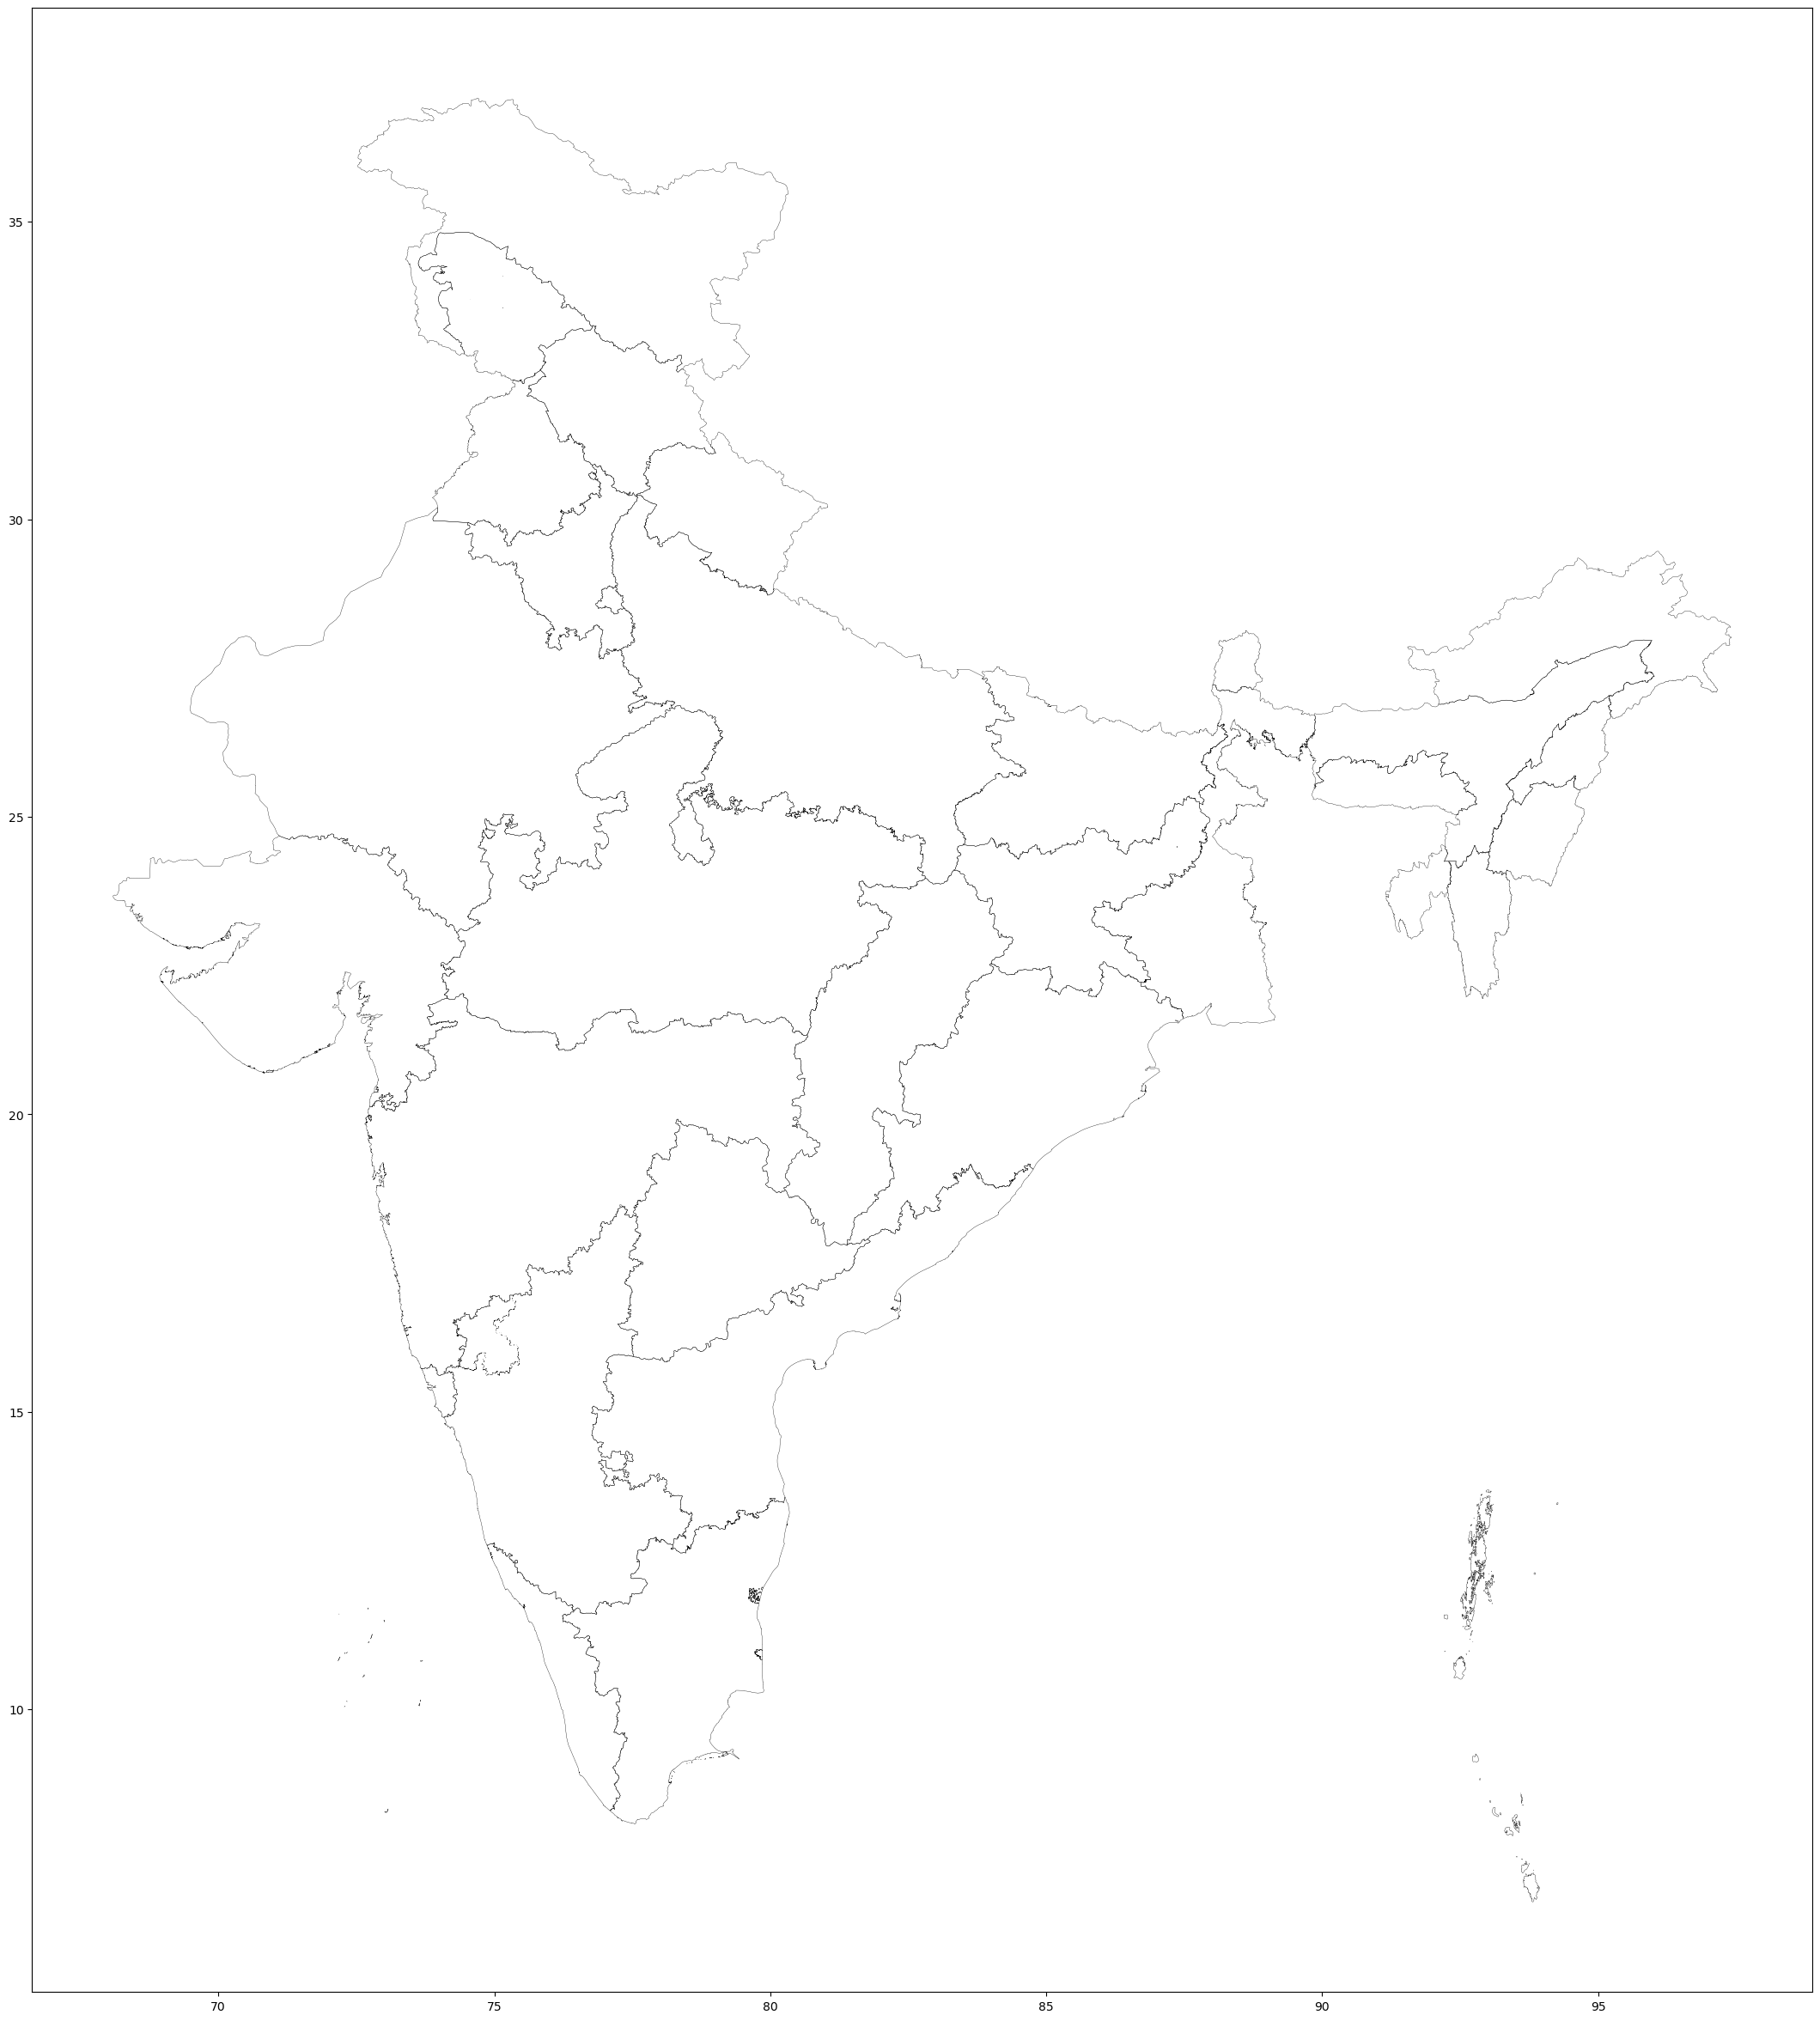

In [66]:
# Plot the India states map, check that it makes sense
#fig, ax = plt.subplots(figsize=(15, 15))
#state_boundaries_gdf.plot(ax=ax, edgecolor="black", facecolor="none")
#plt.show()
state_boundaries_gdf.plot(edgecolor="black", facecolor="none", linewidth=0.25, figsize=(30, 30))

# Step 4: Save or visualize the state boundaries
#state_boundaries_gdf.to_file("state_boundaries.shp")  # Save as shapefile (optional)


<Axes: >

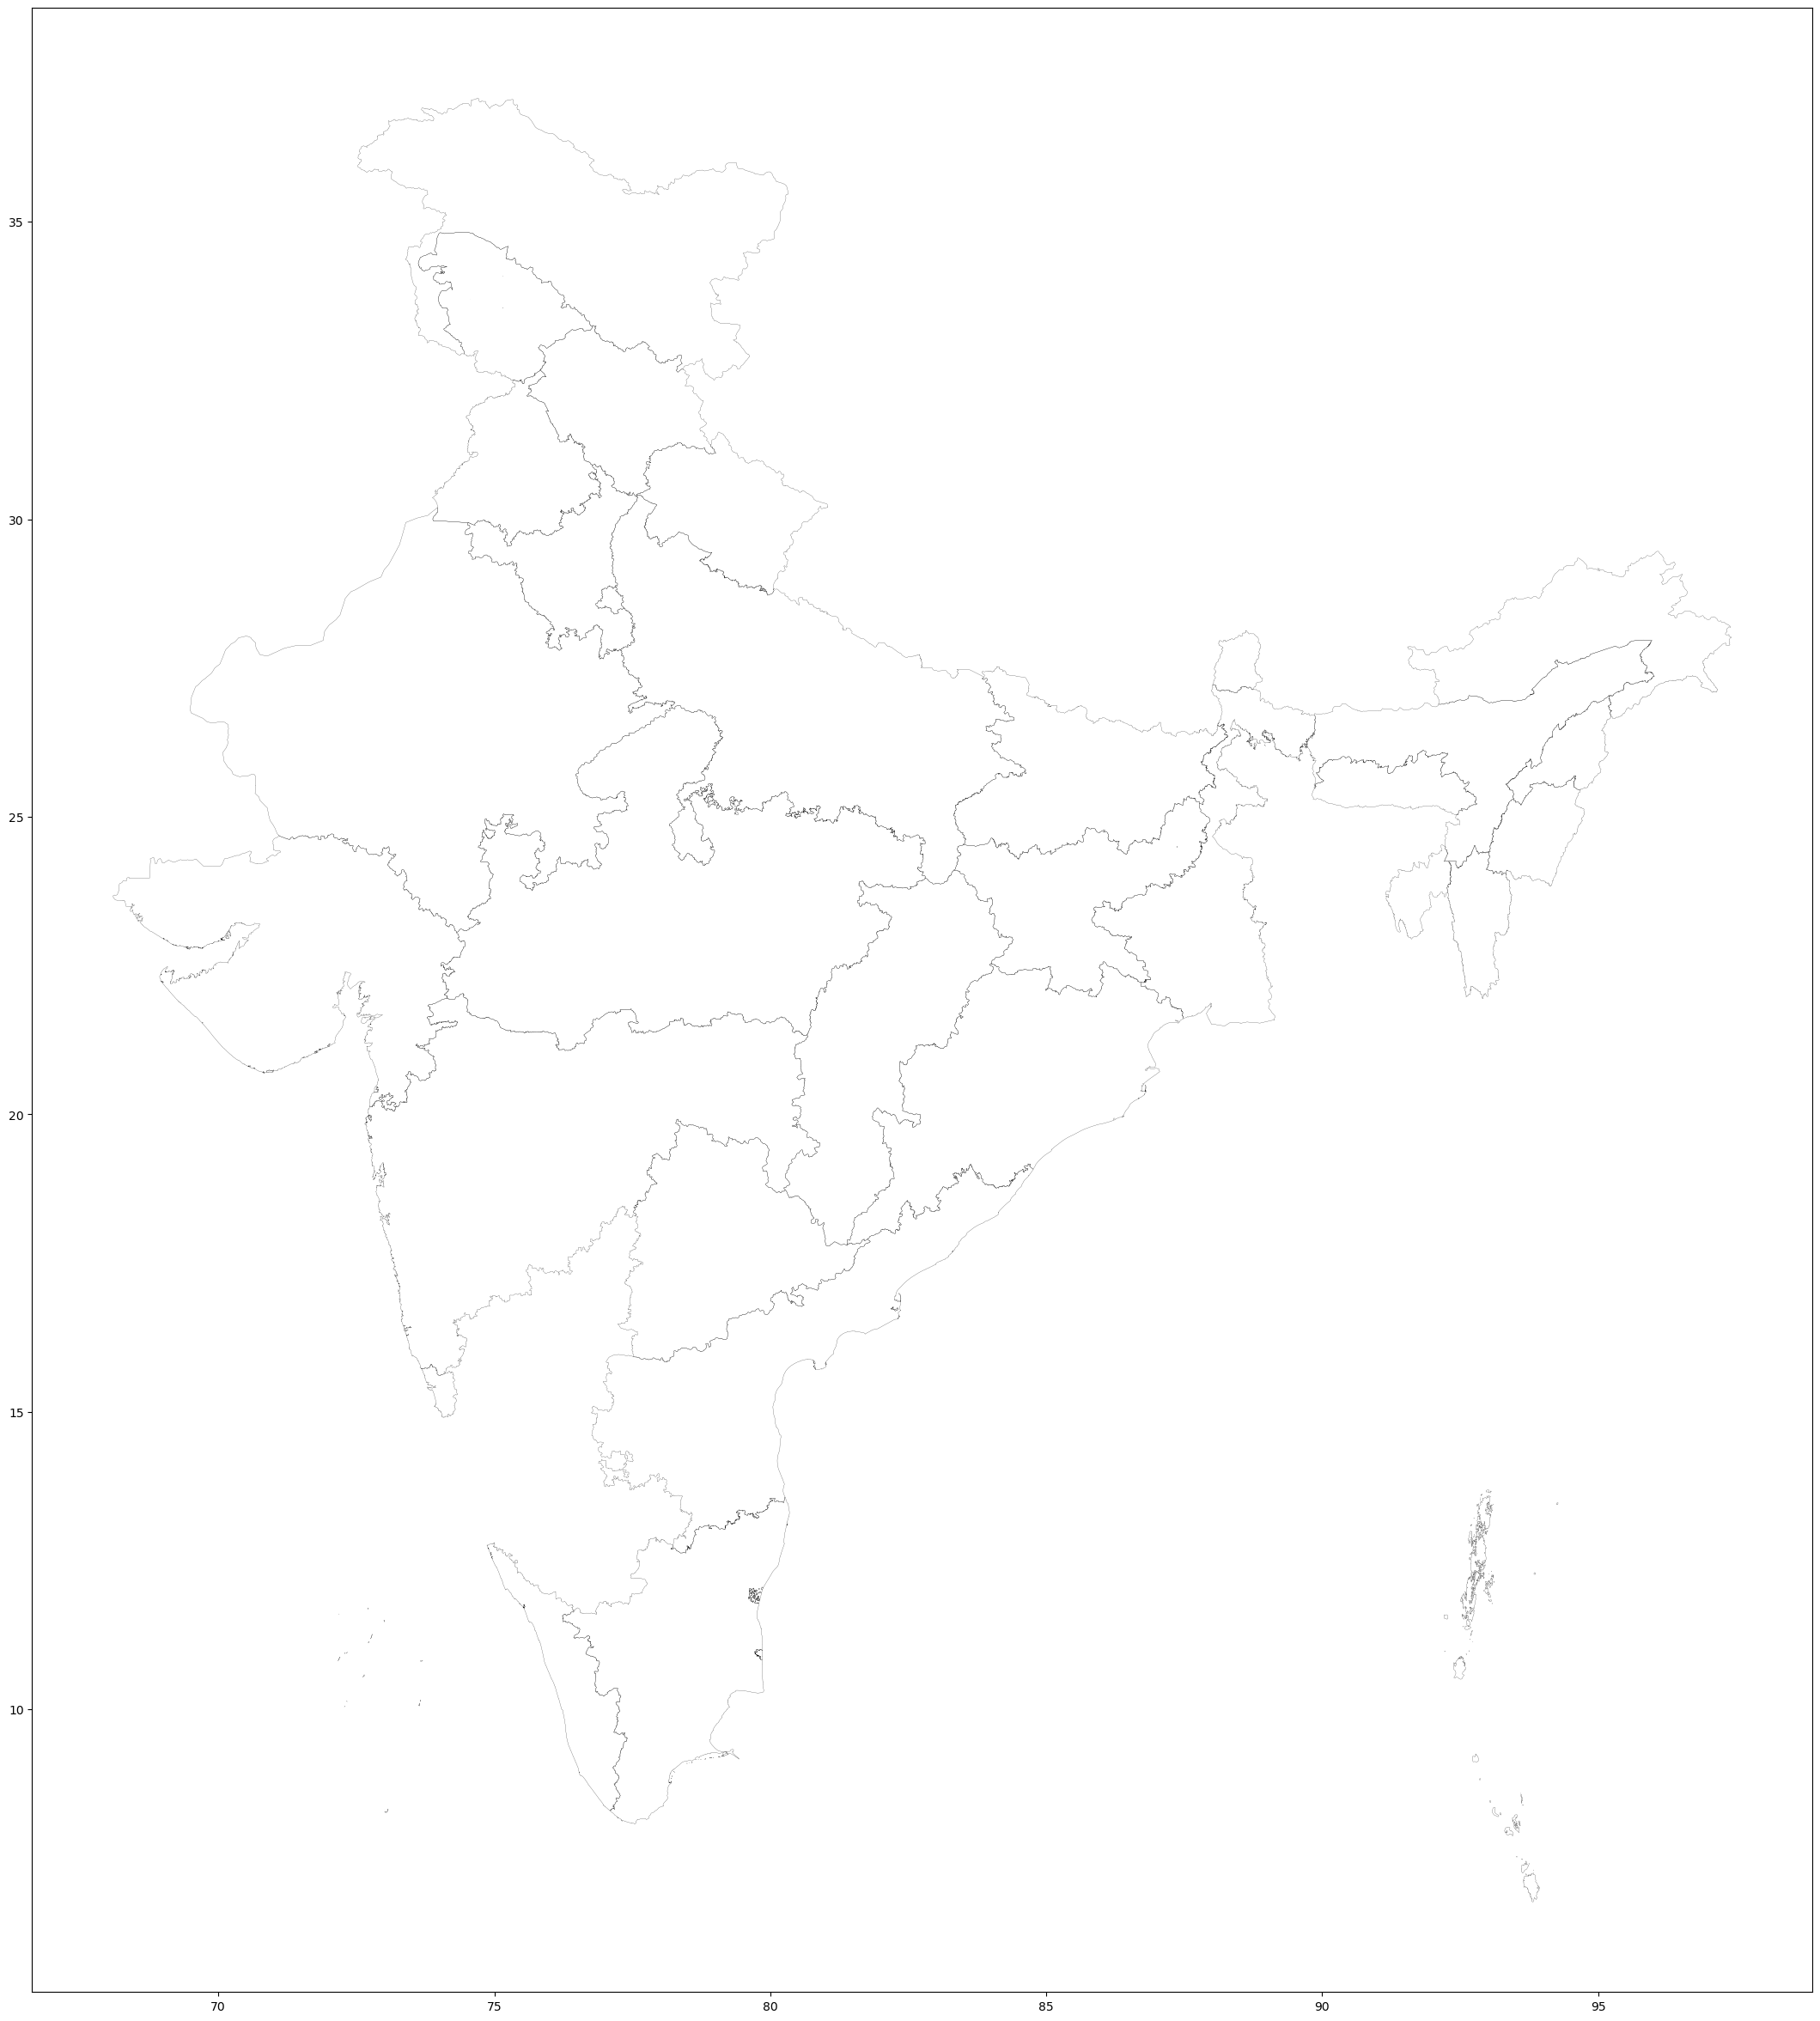

In [229]:
states_no_ka = state_boundaries_gdf.loc[state_boundaries_gdf["State"] != "KARNATAKA"]
states_no_ka.plot(edgecolor="black", facecolor="none", linewidth=0.15, figsize=(30, 30))


In [209]:
karnataka = state_boundaries_gdf[state_boundaries_gdf['State'] == 'KARNATAKA']
karnataka_fixed = karnataka.geometry.unary_union
#karnataka_cleaned = karnataka.geometry[~karnataka.geometry.is_empty].unary_union

In [165]:
from shapely.geometry import MultiPolygon

# Check if Karnataka's geometry is a MultiPolygon
if isinstance(karnataka_fixed, MultiPolygon):
    # Get the individual polygons within the MultiPolygon
    polygons = list(karnataka_fixed.geoms)  # Use .geoms to iterate over polygons

    # Inspect the bounding boxes or areas of the polygons
    for i, polygon in enumerate(polygons):
        print(f"Polygon {i} - Bounding Box: {polygon.bounds}, Area: {polygon.area}")


Polygon 0 - Bounding Box: (74.39331008339371, 14.31137891980137, 74.40196283131968, 14.319644665169221), Area: 5.227014598294252e-05
Polygon 1 - Bounding Box: (74.085687858408, 11.594717370909962, 78.58785418042612, 18.459307984176178), Area: 16.100620911681393
Polygon 2 - Bounding Box: (77.26698208385613, 18.452402117164013, 77.3001392378356, 18.47783945922373), Area: 0.0006151061177822596


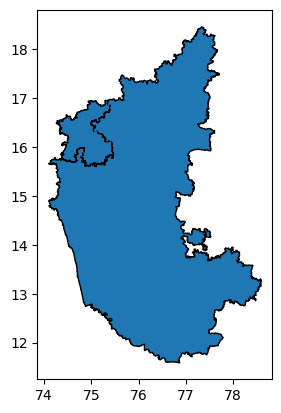

In [213]:
# Get the individual polygons within the MultiPolygon
polygons = list(karnataka_fixed.geoms)  # Use .geoms to iterate over polygons

# Inspect the bounding boxes or areas of the polygons
for i, polygon in enumerate(polygons):
    print(f"Polygon {i} - Bounding Box: {polygon.bounds}, Area: {polygon.area}")
        
# Filter out the unwanted polygon (example: based on area or position)
# For simplicity, let's remove the smallest polygon (adjust criteria as needed)
polygons = [polygon for polygon in polygons if polygon.area > 1]  # Adjust area threshold

# Recreate the MultiPolygon without the unwanted polygon
karnataka_fixed = MultiPolygon(polygons)

# Convert back to a GeoDataFrame for plotting if necessary
karnataka_fixed = gpd.GeoDataFrame(geometry=[karnataka_fixed])

# Ensure CRS matches the original GeoDataFrame
karnataka_fixed.set_crs(state_boundaries_gdf.crs, allow_override=True, inplace=True)

# Plot the corrected Karnataka geometry
karnataka_fixed.plot(edgecolor="black")
plt.show()


In [167]:
karnataka_fixed

,geometry
0,"MULTIPOLYGON (((76.11075 11.97826, 76.10994 11..."


In [189]:
valid_geometries = []

# Iterate over each geometry (polygon or multipolygon) in the 'geometry' column
for geom in karnataka_fixed.geometry:
    if isinstance(geom, MultiPolygon):
        # Iterate over each individual polygon in the MultiPolygon
        valid_polygons = [polygon for polygon in geom.geoms if polygon.area > 16]  # Adjust threshold as needed
        if valid_polygons:
            # If there are valid polygons, add the new MultiPolygon
            valid_geometries.append(MultiPolygon(valid_polygons))

**Plot Swings on maps**

***NDA***

***Interactive map, NDA: swings as colourmap, no arrows***

In [ ]:
# Create a colormap
colors = ['blue', 'white', 'orange']
colormap = LinearColormap(
    colors=colors,
    vmin=-100,
    vmax=100
).to_step(10)
colormap.caption = "NDA Vote Swing: 2024 vs 2019"

# Initialize the map
m = folium.Map(location=[20.5937, 78.9629], zoom_start=5, tiles=None)

# Add GeoJSON data
geojson = folium.GeoJson(
    geo_nda_compare.to_json(),
    style_function=lambda feature: {
        'fillColor': (
            '#D3D3D3' if feature['properties']['Vote Swing'] in [None, ''] 
            else colormap(float(feature['properties']['Vote Swing']))
        ),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['State', 'Constituency', 'Vote Swing'],
        aliases=['State:', 'Constituency:', 'Vote Swing:'],
        localize=True
    )
).add_to(m)

# Fit the map to the bounds of the GeoDataFrame
bounds = geo_nda_compare.total_bounds  # [minx, miny, maxx, maxy]
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# Add the colormap to the map
colormap.add_to(m)

# Inject CSS for a white background
from folium.plugins import FloatImage

css = """
<style>
    .leaflet-container {
        background: #FFFFFF !important;
    }
</style>
"""
folium.Html(css, script=True).add_to(m)

# Save and display the map
m.save(base_dir / "interactive-map-outputs/nda_vote_swing_map.html")
m

***Static NDA plot with swings as arrows instead of colourmap***

***Need to use correct coordinate reference system to plot arrows at constituency centroids***

In [ ]:
print(geo_nda_compare.crs)

In [ ]:
print(india_boundary.crs)

In [ ]:
print(state_boundaries.crs)

In [ ]:
geo_nda_compare = geo_nda_compare.to_crs(epsg=7755)

In [ ]:
india_boundary = india_boundary.to_crs(epsg=7755)

In [ ]:
state_boundaries = state_boundaries.to_crs(epsg=7755)

In [ ]:
# Calculate constituency centroids
geo_nda_compare['centroid'] = geo_nda_compare['geometry'].centroid
geo_nda_compare['centroid_x'] = geo_nda_compare['centroid'].x
geo_nda_compare['centroid_y'] = geo_nda_compare['centroid'].y

In [ ]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
india_boundary.plot(ax=ax, facecolor='#F5F5F5', edgecolor='black', linewidth=0.25, zorder=1)
state_boundaries.plot(ax=ax, color='none', edgecolor='#808080', linewidth=0.25, zorder=1)
geo_nda_compare.plot(linewidth=0.1, edgecolor="#A9A9A9", facecolor="none", ax=ax)

# Get the maximum vote swing for scaling
max_swing = geo_nda_compare['Vote Swing'].abs().max()

# Add arrows
for _, row in geo_nda_compare.iterrows():
    x_start, y_start = row['centroid_x'], row['centroid_y']
    x_end = x_start + (row['Vote Swing'] / max_swing) * 300000  # Adjust scale factor
    y_end = y_start + (abs(row['Vote Swing']) / max_swing) * 300000  # Adjust scale factor
    # Create the arrow with a tip
    arrow = FancyArrowPatch(
        (x_start, y_start), (x_end, y_end),  # Start and end points
        mutation_scale=8,                   # Size of the arrow head (tip)
        color='#0384fc' if row['Vote Swing'] < 0 else '#FF6600',  # Arrow color
        arrowstyle='-|>',                    # Use an arrowhead style
        linewidth=0.5,
        zorder=2  # Ensure the arrows are above the boundaries
    )
    ax.add_patch(arrow)

# Set title and axis options
ax.set_title('NDA Vote Share Swing, 2024 vs 2019', fontsize=16)
plt.axis('off')
#plt.savefig("nda_vote_swing_arrows_map.png", dpi=900, bbox_inches="tight")
plt.show()

***NDA Interactive map with swings as arrows***

In [ ]:
# Data cleaning steps

In [237]:
# Ensure the CRS is correct (in latitude/longitude coordinates, EPSG:4326)
print(geo_nda_compare.crs)
geo_nda_compare = geo_nda_compare.to_crs(epsg=4326)

EPSG:4326


In [239]:
# Calculate constituency centroids
# Step 1: Reproject the GeoDataFrame to a projected CRS
geo_projected = geo_nda_compare_nomiss.to_crs(epsg=3857)  # Web Mercator or another suitable projected CRS

# Step 2: Calculate centroids in the projected CRS
geo_projected['centroid'] = geo_projected['geometry'].centroid

# Step 3: Reproject centroids back to geographic CRS (EPSG:4326)
geo_nda_compare = geo_nda_compare.to_crs(epsg=4326)
geo_nda_compare_nomiss = geo_nda_compare_nomiss.to_crs(epsg=4326)
geo_nda_compare_nomiss['centroid'] = geo_projected['centroid'].to_crs(epsg=4326)

# Now, geo_nda_compare['centroid'] contains valid lat/lon values

***First attempt: swings as straight polylines***

In [265]:
geo_nda_compare["vote_swing_string_formatted"] = geo_nda_compare["Vote Swing"].round(2)

In [267]:
geo_nda_compare["vote_swing_string_formatted"] = geo_nda_compare["vote_swing_string_formatted"].fillna("-")

In [269]:
# Create custom HTML tooltips because native ones are ugly
geo_nda_compare['custom_tooltip'] = geo_nda_compare.apply(
    lambda row: f"""
    <div style="
        font-size: 12px; 
        color: black; 
        background-color: white; 
        padding: 5px; 
        margin: 0;">
        State: <b>{row["state_title"]}</b><br>
        Constituency: <b>{row["constituency_title"]}</b><br>
        NDA Vote Swing: <b>{row["vote_swing_string_formatted"]}%</b>
    </div>
    """,
    axis=1
)

In [ ]:
# Initialize the map
m = folium.Map(location=[20.5937, 78.9629], zoom_start=5, tiles=None)

# Add constituency boundaries
folium.GeoJson(
    geo_nda_compare[['geometry', 'custom_tooltip']],
    style_function=lambda feature: {
        'color': '#808080',  # Constituency borders in grey
        'weight': 0.5,
        'fillColor': '#F0F0F0',  # Fill color in light grey
        'fillOpacity': 0.3,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['custom_tooltip'],
        localize=True,
        sticky=True,
        style=(
            "background-color: white; color: black; font-size: 12px;"
            "padding: 5px; margin: 0; box-shadow: none; width: auto; height: auto;"
        ),
        labels=False,  # Ensures only your custom content appears
    ),
).add_to(m)

# Fit the map to the bounds of the GeoDataFrame
bounds = geo_nda_compare.total_bounds  # [minx, miny, maxx, maxy]
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# Add arrows for each district based on the vote swing
max_swing = geo_nda_compare_nomiss['Vote Swing'].abs().max()  # Get max swing to scale the arrows

for _, row in geo_nda_compare_nomiss.iterrows():
    # Get centroid coordinates for the arrow start point
    x_start, y_start = row['centroid'].x, row['centroid'].y
    
    # Calculate the arrow's end coordinates based on the vote swing
    scale_factor = 1  # You can adjust this value to control arrow size
    x_end = x_start + (row['Vote Swing'] / max_swing) * scale_factor
    y_end = y_start + (abs(row['Vote Swing']) / max_swing) * scale_factor
    
    # Arrow color based on the swing (blue for away from NDA, orange for towards NDA)
    arrow_color = '#0384fc' if row['Vote Swing'] < 0 else '#FF6600'
    
    # Create a polyline (line) to represent the arrow
    arrow_line = folium.PolyLine(
        locations=[[y_start, x_start], [y_end, x_end]],  # Using [lat, lon] for coordinates
        color=arrow_color,
        weight=3,
        opacity=0.8
    )

    # Add a tooltip to the arrow
    html = f"""
    <div style="
        font-size: 12px; 
        color: black; 
        background-color: white; 
        padding: 5px; 
        margin: 0; 
        width: auto; 
        height: auto; 
        box-shadow: none;">
        State: <b>{row['state_title']}</b><br>
        Constituency: <b>{row['constituency_title']}</b><br>
        NDA Vote Swing: <b>{row['Vote Swing']:.2f}%</b>
    </div>
    """
    tooltip = folium.Tooltip(html)
    arrow_line.add_child(tooltip)
    
    # Add the arrow to the map
    arrow_line.add_to(m)

# Save the map as HTML
m.save(base_dir / "interactive-map-outputs/nda_vote_swing_arrows_tooltip_map.html")
m

***Second attempt: swings as proper arrows, with custom SVG arrowheads atop polylines***

In [247]:
# Function to generate the arrow SVGs for both colors (without scaling)
def generate_arrowhead_svg():
    # Define the static SVGs for blue and orange arrows (no scaling)
    blue_arrowhead_svg = """
    <svg xmlns="http://www.w3.org/2000/svg" width="24" height="24" viewBox="-6 -6 36 36">
        <polygon points="12,0 0,24 24,24" fill="#0384fc" transform="rotate(-45 12 12)" />
    </svg>
    """
    
    orange_arrowhead_svg = """
    <svg xmlns="http://www.w3.org/2000/svg" width="24" height="24" viewBox="-6 -6 36 36">
        <polygon points="12,0 0,24 24,24" fill="#FF6600" transform="rotate(45 12 12)" />
    </svg>
    """
    
    # Encode the SVGs as Base64
    encoded_blue_arrowhead_svg = base64.b64encode(blue_arrowhead_svg.encode('utf-8')).decode('utf-8')
    encoded_orange_arrowhead_svg = base64.b64encode(orange_arrowhead_svg.encode('utf-8')).decode('utf-8')

    # Return the data URIs for both arrows
    return f"data:image/svg+xml;base64,{encoded_blue_arrowhead_svg}", f"data:image/svg+xml;base64,{encoded_orange_arrowhead_svg}"

In [ ]:
# Initialize the map
m = folium.Map(location=[20.5937, 78.9629], zoom_start=5, tiles=None)

# Globally remove clickable boundaries
m.get_root().html.add_child(folium.Element("""
        <style>
            path {
                outline: none;
            }
        </style>
    """))

# Title and Sub-Heading HTML
title_and_legend_html = '''
    <div style="position: fixed; top: 10px; left: 50%; transform: translateX(-50%); 
                background-color: rgba(255, 255, 255, 0.9); padding: 10px; 
                border-radius: 8px; border: 1px solid grey; text-align: center;
                z-index: 9999; font-family: Arial, sans-serif;">
        <h3 style="margin: 0; font-size: 15px; font-weight: bold;">Indian general election, constituency-wise change in NDA vote share, 2019-2024 (% points)</h3>
        <p style="margin: 5px 0 0; font-size: 13px;">
            <span style="display: inline-block; margin-left: 8px;">
                <svg width="20" height="10">
                    <line x1="5" y1="5" x2="20" y2="5" stroke="#0384fc" stroke-width="2"></line>
                    <polygon points="5,2 0,5 5,8" fill="#0384fc"></polygon>
                </svg>
                Swing towards Opposition
            </span>
            <span style="display: inline-block; margin-right: 8px;">
                <svg width="20" height="10">
                    <line x1="0" y1="5" x2="15" y2="5" stroke="#FF6600" stroke-width="2"></line>
                    <polygon points="15,2 20,5 15,8" fill="#FF6600"></polygon>
                </svg>
                Swing towards NDA
            </span>
        </p>
    </div>
'''

# Add the title and legend to the map
m.get_root().html.add_child(Element(title_and_legend_html))

# Add constituency boundaries
folium.GeoJson(
    geo_nda_compare[['geometry', 'custom_tooltip']],
    style_function=lambda feature: {
        'color': '#808080',  # Constituency borders in grey
        'weight': 0.3,
        'fillColor': '#F9F9F9',  # Fill color in light grey
        'fillOpacity': 0.3,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['custom_tooltip'],
        localize=True,
        sticky=True,
        style=(
            "background-color: white; color: black; font-size: 12px;"
            "padding: 5px; margin: 0; box-shadow: none; width: auto; height: auto;"
        ),
        labels=False,  # Ensures only your custom content appears
    ),
).add_to(m)

# Add state boundaries
folium.GeoJson(
    states_no_ka["geometry"],
    style_function=lambda feature: {
        'color': '#808080',  # Color of the boundary line
        'weight': 1,       # Line thickness
        'fillColor': "none",
        'fillOpacity': 0,  # No fill for the boundary
    }
).add_to(m)

# Fit the map to the bounds of the GeoDataFrame
bounds = geo_nda_compare.total_bounds  # [minx, miny, maxx, maxy]
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# Generate the base64-encoded SVGs for blue and orange arrows
blue_arrowhead_uri, orange_arrowhead_uri = generate_arrowhead_svg()

# Add arrows for each district based on the vote swing
max_swing = geo_nda_compare_nomiss['Vote Swing'].abs().max()  # Get max swing to scale the arrows

for _, row in geo_nda_compare_nomiss.iterrows():
    # Get centroid coordinates for the arrow start point
    x_start, y_start = row['centroid'].x, row['centroid'].y
    
    # Calculate the arrow's end coordinates based on the vote swing
    scale_factor = 1  # You can adjust this value to control arrow size
    x_end = x_start + (row['Vote Swing'] / max_swing) * scale_factor
    y_end = y_start + (abs(row['Vote Swing']) / max_swing) * scale_factor

    # Arrowhead size based on the vote swing
    arrowhead_dim = 5 + (abs(row['Vote Swing']) / max_swing) * 15  # this is in pixels, not lat/lon, and is based on experimentation
    
    # Arrow color based on the swing (blue for away from NDA, orange for towards NDA)
    arrow_color = '#0384fc' if row['Vote Swing'] < 0 else '#FF6600'
    
    # Create a polyline (line) to represent the arrow
    arrow_line = folium.PolyLine(
        locations=[[y_start, x_start], [y_end, x_end]],  # Using [lat, lon] for coordinates
        color=arrow_color,
        weight=2,
        opacity=0.9
    )

    # Define custom tooltip to add to polyline and arrowhead
    html = f"""
    <div style="
        font-size: 12px; 
        color: black; 
        background-color: white; 
        padding: 5px; 
        margin: 0; 
        width: auto; 
        height: auto; 
        box-shadow: none;">
        State: <b>{row['state_title']}</b><br>
        Constituency: <b>{row['constituency_title']}</b><br>
        NDA Vote Swing: <b>{row['Vote Swing']:.2f}%</b>
    </div>
    """
    line_tooltip = folium.Tooltip(html)
    marker_tooltip = folium.Tooltip(html)

    # Add tooltip to polyline
    arrow_line.add_child(line_tooltip)

    # Add the arrow to the map
    arrow_line.add_to(m)

    # Define the arrowhead file to use
    if row['Vote Swing'] < 0:
        arrowhead_uri = blue_arrowhead_uri  # Blue arrow for negative swing
        arrowhead_anchor = (arrowhead_dim-(2*(arrowhead_dim/9)), arrowhead_dim-(2*(arrowhead_dim/9)))
    else:
        arrowhead_uri = orange_arrowhead_uri  # Orange arrow for positive swing
        arrowhead_anchor = (2*(arrowhead_dim/9), arrowhead_dim-(2*(arrowhead_dim/9)))
        
    arrow_icon = folium.CustomIcon(arrowhead_uri, icon_size=(arrowhead_dim, arrowhead_dim), icon_anchor=arrowhead_anchor)
    
    # Add the arrowhead as a custom marker
    folium.Marker(
        location=[y_end, x_end],  # The arrow tip coordinates
        icon=arrow_icon,
        tooltip=marker_tooltip
    ).add_to(m)

# Save the map as HTML
m.save(base_dir / "interactive-map-outputs/nda_vote_swing_arrows_map_v2.html")
m

***The above code WORKED***

***With custom SVG for the full arrow incl the line***

In [50]:
# Function to generate the arrow SVGs for both colors (without scaling)
def generate_arrow_svg():
    # Define the static SVGs for blue and orange arrows (no scaling)
    blue_arrow_svg = """
    <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 100 60" preserveAspectRatio="none">
        <!-- Line (blue) with -45 degrees rotation -->
        <line x1="25" y1="30" x2="0" y2="0" stroke="#0384fc" stroke-width="1" />
        <!-- Arrowhead (blue) with -45 degrees rotation -->
        <polygon points="4,0 0,0 0,4" fill="#0384fc" />
    </svg>
    """
    
    orange_arrow_svg = """
    <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 100 60" preserveAspectRatio="none">
        <!-- Line (orange) with +45 degrees rotation -->
        <line x1="0" y1="30" x2="30" y2="0" stroke="#FF6600" stroke-width="1" />
        <!-- Arrowhead (orange) with +45 degrees rotation -->
        <polygon points="25,0 30.5,0 30.5,4.5" fill="#FF6600" />
    </svg>
    """
    
    # Encode the SVGs as Base64
    encoded_blue_svg = base64.b64encode(blue_arrow_svg.encode('utf-8')).decode('utf-8')
    encoded_orange_svg = base64.b64encode(orange_arrow_svg.encode('utf-8')).decode('utf-8')

    # Return the data URIs for both arrows
    return f"data:image/svg+xml;base64,{encoded_blue_svg}", f"data:image/svg+xml;base64,{encoded_orange_svg}"

In [ ]:
# Initialize the map
m = folium.Map(location=[20.5937, 78.9629], zoom_start=5, tiles=None)

# Globally remove clickable boundaries
m.get_root().html.add_child(folium.Element("""
        <style>
            path {
                outline: none;
            }
        </style>
    """))

# Add constituency boundaries
folium.GeoJson(
    geo_nda_compare[['geometry', 'custom_tooltip']],
    style_function=lambda feature: {
        'color': '#808080',  # Constituency borders in grey
        'weight': 0.5,
        'fillColor': '#F0F0F0',  # Fill color in light grey
        'fillOpacity': 0.3,
        'outline': 'none'  # Prevent focus outline
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['custom_tooltip'],
        localize=True,
        sticky=True,
        style=(
            "background-color: white; color: black; font-size: 12px;"
            "padding: 5px; margin: 0; box-shadow: none; width: auto; height: auto;"
        ),
        labels=False,  # Ensures only your custom content appears
    ),
).add_to(m)

# Fit the map to the bounds of the GeoDataFrame
bounds = geo_nda_compare.total_bounds  # [minx, miny, maxx, maxy]
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# Generate the base64-encoded SVGs for blue and orange arrows
blue_arrow_uri, orange_arrow_uri = generate_arrow_svg()

# Add arrows for each district based on the vote swing
max_swing = geo_nda_compare_nomiss['Vote Swing'].abs().max()  # Get max swing to scale the arrows

for _, row in geo_nda_compare_nomiss.iterrows():
    # Get centroid coordinates for the arrow start point
    x_start, y_start = row['centroid'].x, row['centroid'].y    

    # Calculate dynamic scaling for the length and size of the arrowhead
    length = 20 + (abs(row['Vote Swing']) / max_swing) * 100  
    icon_width = length
    icon_height = length * 0.5
    
    # Choose the correct arrow URI based on the Vote Swing
    if row['Vote Swing'] < 0:
        arrow_uri = blue_arrow_uri  # Blue arrow for negative swing
        icon_anchor = (icon_width, icon_height)
    else:
        arrow_uri = orange_arrow_uri  # Orange arrow for positive swing
        icon_anchor = (0, icon_height)
    
    # Define custom tooltip to add to polyline and arrowhead
    html = f"""
    <div style="
        font-size: 12px; 
        color: black; 
        background-color: white; 
        padding: 5px; 
        margin: 0; 
        width: auto; 
        height: auto; 
        box-shadow: none;">
        State: <b>{row['state_title']}</b><br>
        Constituency: <b>{row['constituency_title']}</b><br>
        NDA Vote Swing: <b>{row['Vote Swing']:.2f}%</b>
    </div>
    """
    marker_tooltip = folium.Tooltip(html)

    # Create the DivIcon with the scaled arrow SVG as an image
    icon_html = f"""
    <div style="width: {icon_width}px; height: {icon_height}px; position: relative;">
        <img src="{arrow_uri}" style="width: 100%; height: 100%; stroke-width: 10px">
    </div>
    """
    
    # Create the DivIcon for the marker
    arrow_icon = folium.DivIcon(html=icon_html, 
                                icon_size=(icon_width, icon_height), 
                                icon_anchor=(0, icon_height))

    # Add the marker with the custom SVG icon
    folium.Marker(
        location=[row['centroid'].y, row['centroid'].x],  # The start coordinates (centroid)
        icon=arrow_icon,  # Set the custom arrow as the marker icon
        tooltip=marker_tooltip  # Tooltip for the marker
    ).add_to(m)

# Save the map as HTML
m.save(base_dir / "interactive-map-outputs/nda_vote_swing_arrows_map_rotation_2.html")
m

**BJP Comparison**

***Merge 2019 and 2024 datasets, calculate vote swing***

In [ ]:
geo_bjp_2019 = gpd.read_file("geo_bjp_2019.geojson")

In [ ]:
geo_bjp_2024 = gpd.read_file("geo_bjp_2024.geojson")

In [ ]:
# label cols as 2019 and 2024
geo_bjp_2019.columns

In [ ]:
geo_bjp_2024.columns

In [ ]:
cols_to_tag = ['Candidate', 'Party', 'Total Votes', 'Total Votes Cast', 'Vote Share (%)']

# Rename columns in the 2019 dataset
geo_bjp_2019 = geo_bjp_2019.rename(columns={col: f"{col} (2019)" for col in cols_to_tag})

# Rename columns in the 2024 dataset
geo_bjp_2024 = geo_bjp_2024.rename(columns={col: f"{col} (2024)" for col in cols_to_tag})

In [ ]:
geo_bjp_2024.columns

In [ ]:
cols_to_drop_2019 = ['Total Votes (2019)', 'Total Votes Cast (2019)', 'constituency_title', 'state_title', 'Reserved status']
cols_to_drop_2024 = ['Total Votes (2024)', 'Total Votes Cast (2024)']
geo_bjp_2019 = geo_bjp_2019.drop(columns=[col for col in cols_to_drop_2019 if col in geo_bjp_2019.columns])
geo_bjp_2024 = geo_bjp_2024.drop(columns=[col for col in cols_to_drop_2024 if col in geo_bjp_2024.columns])

In [ ]:
# Replace BJP with full form in 2019
geo_bjp_2019["Party (2019)"] = geo_bjp_compare["Party (2019)"].replace({'BJP' : 'BHARATIYA JANATA PARTY'})

In [ ]:
geo_bjp_compare = pd.merge(geo_bjp_2019, geo_bjp_2024, on=["State", "Constituency", "geometry"], how="outer")

In [ ]:
geo_bjp_compare

In [ ]:
geo_bjp_compare[(geo_bjp_compare["Candidate (2019)"].isna()) | (geo_bjp_compare["Candidate (2024)"].isna())]

In [ ]:
geo_bjp_compare["Vote Swing"] = geo_bjp_compare["Vote Share (%) (2024)"] - geo_bjp_compare["Vote Share (%) (2019)"]

In [ ]:
geo_bjp_compare

***Map BJP swings***

In [ ]:
# Basic map, BJP
# No BJP candidates - Kashmir Valley; plus Assam will be dealt with later
bjp_candidates = geo_bjp_compare[geo_bjp_compare["Vote Swing"].notna()]
no_bjp_candidates = geo_bjp_compare[geo_bjp_compare["Vote Swing"].isna()]

# Define a diverging colormap (blue for negative, white for zero, orange for positive)
cmap = mcolors.LinearSegmentedColormap.from_list('diverging_cmap', ['#0000FF', '#FFFFFF', '#FF6600'])

# Plot the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
bjp_candidates.plot(column="Vote Swing", 
                    cmap=cmap, 
                    linewidth=0.1, 
                    edgecolor="gray", 
                    ax=ax, 
                    legend=True, 
                    vmin = -100, 
                    vmax = 100)

no_bjp_candidates.plot(color="#D3D3D3", linewidth=0.05, edgecolor="gray", ax=ax)

# Add a title
ax.set_title("BJP 2024 vs 2019 vote swing", fontsize=16)

# Remove axis for better visualization
ax.axis('off')

# Show the plot
plt.show()

***Static plot with swings as arrows***

In [ ]:
print(geo_bjp_compare.crs)

In [ ]:
print(india_boundary.crs)

In [ ]:
print(state_boundaries.crs)

In [ ]:
geo_bjp_compare = geo_bjp_compare.to_crs(epsg=7755)

In [ ]:
# Calculate constituency centroids
geo_bjp_compare['centroid'] = geo_bjp_compare['geometry'].centroid
geo_bjp_compare['centroid_x'] = geo_bjp_compare['centroid'].x
geo_bjp_compare['centroid_y'] = geo_bjp_compare['centroid'].y

In [ ]:
bjp_candidates = geo_bjp_compare[geo_bjp_compare["Vote Swing"].notna()]
no_bjp_candidates = geo_bjp_compare[geo_bjp_compare["Vote Swing"].isna()]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
india_boundary.plot(ax=ax, facecolor='#FAFAFA', edgecolor='black', linewidth=0.25, zorder=1)
state_boundaries.plot(ax=ax, color='none', edgecolor='#808080', linewidth=0.25, zorder=1)
bjp_candidates.plot(linewidth=0.1, edgecolor="#A9A9A9", facecolor="none", ax=ax)
no_bjp_candidates.plot(color="#D3D3D3", linewidth=0.05, edgecolor="gray", ax=ax)

# Get the maximum vote swing for scaling
max_swing = geo_bjp_compare['Vote Swing'].abs().max()

# Add arrows
for _, row in geo_bjp_compare.iterrows():
    x_start, y_start = row['centroid_x'], row['centroid_y']
    x_end = x_start + (row['Vote Swing'] / max_swing) * 300000  # Adjust scale factor
    y_end = y_start + (abs(row['Vote Swing']) / max_swing) * 300000  # Adjust scale factor
    # Create the arrow with a tip
    arrow = FancyArrowPatch(
        (x_start, y_start), (x_end, y_end),  # Start and end points
        mutation_scale=8,                   # Size of the arrow head (tip)
        color='#0384fc' if row['Vote Swing'] < 0 else '#FF6600',  # Arrow color
        arrowstyle='-|>',                    # Use an arrowhead style
        linewidth=0.5,
        zorder=2  # Ensure the arrows are above the boundaries
    )
    ax.add_patch(arrow)

# Set title and axis options
ax.set_title('BJP Vote Share Swing, 2024 vs 2019', fontsize=16)
plt.axis('off')
plt.savefig("bjp_vote_swing_arrows_map.png", dpi=900, bbox_inches="tight")
plt.show()